#### 이미지 데이터에 LIME 적용하기 

(-0.5, 1279.5, 1279.5, -0.5)

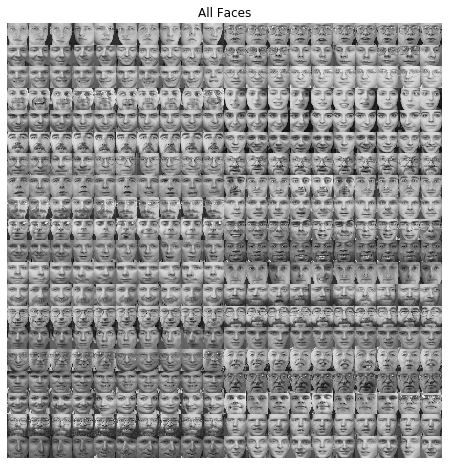

In [4]:
#scikit-image 패키지를 활용해서 올리베티 얼굴 데이터를 로드하고 확인하는 코드 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage

from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

#이미지 흑백으로 만들고 LIME이 처리할 수 있는 형태로 변환하디 
X_vec = np.stack([gray2rgb(iimg)
                  for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8) #이미지에 대응되는 레이블 (정수형으로 저장)

%matplotlib inline 
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
ax1.imshow(montage(X_vec[:,:,:,0]),
           cmap ='gray',
           interpolation='none')
ax1.set_title('All Faces')
ax1.axis('off')

(-0.5, 63.5, 63.5, -0.5)

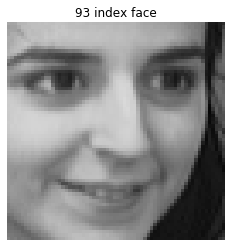

In [5]:
#이미지 데이터 한 장을 그리는 코드 
index = 93 
plt.imshow(X_vec[index], cmap='gray')
plt.title('{} index face'.format(index))
plt.axis('off')

In [6]:
#tensorflow를 이용한 분류 모델을 LIME에서 사용할 수 있게 컨벤션을 맞춰주는 코드 
def predict_proba(image):
    return session.run(model_predict,
                       feed_dict ={preprocessed_image : image})

In [7]:
#train_test split을 사용하여 X_vec, y_vec으로부터 학습용과 테스트용 데이터셋 분리 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec,
                                                    y_vec,
                                                    train_size = 0.7)

In [12]:
#mlp가 학습할 수 있게 이미지 전처리를 수행하는 파이프라인 생성 
from sklearn.pipeline import Pipeline 
from sklearn.neural_network import MLPClassifier

class Pipestep(object):
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = Pipestep(lambda img_list:
    [rgb2gray(img) for img in img_list])

flatten_step = Pipestep(lambda img_list:
    [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('MLP', MLPClassifier(
        activation = 'relu',
        hidden_layer_sizes=(400,40),
        random_state=1
    ))
])

In [13]:
simple_pipeline.fit(X_train, y_train)

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('Make Gray', <__main__.Pipestep object at 0x7f3997b72518>),
                ('Flatten Image', <__main__.Pipestep object at 0x7f3997b72588>),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), random_state=1))])

In [14]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.67      0.80         3
           2       0.40      1.00      0.57         2
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         3
           5       0.33      0.75      0.46         4
           6       0.67      0.67      0.67         3
           7       1.00      1.00      1.00         4
           8       0.67      0.80      0.73         5
           9       1.00      1.00      1.00         1
          10       0.67      0.67      0.67         3
          11       0.67      1.00      0.80         4
          12       0.33      0.17      0.22         6
          13       1.00      1.00      1.00         4
          14       0.00      0.00      0.00         4
          15       1.00      0.25      0.40         4
          16       1.00      0.67      0.80         3
          17       0.80    

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
#mlp가 학습할 수 있게 이미지 전처리를 수행하는 파이프라인 생성 
#전처리 과정에서 normalize 추가 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer 
from sklearn.neural_network import MLPClassifier

class Pipestep(object):
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = Pipestep(lambda img_list:
    [rgb2gray(img) for img in img_list])

flatten_step = Pipestep(lambda img_list:
    [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('MLP', MLPClassifier(
        activation = 'relu',
        hidden_layer_sizes=(400,40),
        random_state=1
    ))
])

simple_pipeline.fit(X_train, y_train)

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('Make Gray', <__main__.Pipestep object at 0x7f3997b75eb8>),
                ('Flatten Image', <__main__.Pipestep object at 0x7f3997b75f60>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(hidden_layer_sizes=(400, 40), random_state=1))])

In [18]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.67      0.80         3
           2       0.50      0.50      0.50         2
           3       0.67      1.00      0.80         2
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       0.80      1.00      0.89         4
           8       1.00      0.60      0.75         5
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      0.17      0.29         6
          13       1.00      1.00      1.00         4
          14       0.75      0.75      0.75         4
          15       1.00      0.75      0.86         4
          16       1.00      0.67      0.80         3
          17       0.80    

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [20]:
#mlp가 학습할 수 있게 이미지 전처리를 수행하는 파이프라인 생성 
#전처리 과정에서 normalize 추가 
#파라미터 수정 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer 
from sklearn.neural_network import MLPClassifier

class Pipestep(object):
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = Pipestep(lambda img_list:
    [rgb2gray(img) for img in img_list])

flatten_step = Pipestep(lambda img_list:
    [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('MLP', MLPClassifier(
        activation = 'relu',
        alpha = 1e-7,
        epsilon = 1e-6,
        hidden_layer_sizes=(800,120),
        random_state=1
    ))
])

simple_pipeline.fit(X_train, y_train)

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('Make Gray', <__main__.Pipestep object at 0x7f3997b75a58>),
                ('Flatten Image', <__main__.Pipestep object at 0x7f3997b752e8>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=1))])

In [21]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3
           2       1.00      0.50      0.67         2
           3       0.40      1.00      0.57         2
           4       1.00      0.67      0.80         3
           5       0.80      1.00      0.89         4
           6       1.00      1.00      1.00         3
           7       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         5
           9       0.25      1.00      0.40         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      0.17      0.29         6
          13       0.80      1.00      0.89         4
          14       1.00      0.75      0.86         4
          15       1.00      0.50      0.67         4
          16       0.75      1.00      0.86         3
          17       1.00    

In [22]:
#lime의 이미지 설명체와 이미지 분할 알고리즘을 선언하는 코드 
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

#이미지 분할 알고리즘: quickshift(기본), slic, felzenszwalb 
segmenter = SegmentationAlgorithm('slic',
                                  n_segments = 100, #이미지 분할 조각 개수 
                                  compactness = 1, #분할한 이미지 조각으로부터 유사한 파트를 합치는 함수 
                                  sigma = 1) #분할한 이미지를 부드럽게 깍아주는 정도 

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
%%time 

olivetti_test_index = 0 

exp = explainer.explain_instance(X_test[olivetti_test_index],
                                 classifier_fn = simple_pipeline.predict_proba,
                                 top_labels = 6, 
                                 num_samples = 1000,
                                 segmentation_fn = segmenter)

/home/sojihae99/miniconda3/envs/xai/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)
100%|██████████| 1000/1000 [00:01<00:00, 970.10it/s]


CPU times: user 16.2 s, sys: 18.4 s, total: 34.6 s
Wall time: 1.16 s


Text(0.5, 1.0, 'Show output image only')

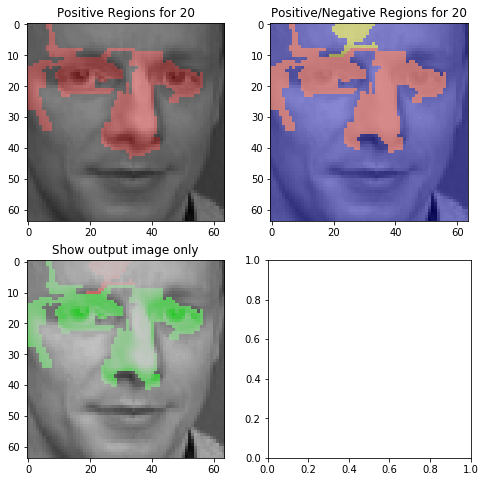

In [24]:
from skimage.color import label2rgb

#캔버스 설정하기 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (8,8))

#예측에 도움이 되는 세그먼트 출력하기 
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = True,
                                    num_features = 8,
                                    hide_rest = False)

ax1.imshow(label2rgb(mask, temp, bg_label = 0),
           interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))

#모든 세그먼트 출력하기 
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = False,
                                    num_features = 8, 
                                    hide_rest = False)

ax2.imshow(label2rgb(4 - mask, temp, bg_label = 0), 
           interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[olivetti_test_index]))

#이미지만 출력 
ax3.imshow(temp, interpolation = 'nearest')
ax3.set_title('Show output image only')